# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


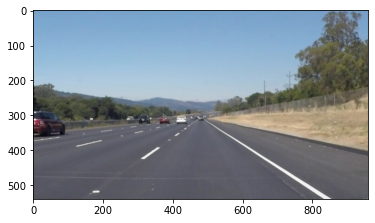

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [6]:
# Import new dependencies:
import os
import pandas as pd

In [7]:
%cd D:/Study/Lane-Finding-ND/CarND-LaneLines-P1

D:\Study\Lane-Finding-ND\CarND-LaneLines-P1


In [8]:
# Define working path:
path = 'D:/Study/Lane-Finding-ND/CarND-LaneLines-P1'
tst_input = '/test_images/'
output = '/test_images_output/'

In [9]:
# PIPELINE SCHEME:
"""
1 - Convert to grayscale
2 - Apply Gaussian smoothing
3 - Apply Canny
4 - Create Mask
5 - Apply Hough transform
6 - Manipulate Hough lines
7 - Draw extrapolated lines - I will implement this step in a second function to add flexibility to the framework.
"""

'\n1 - Convert to grayscale\n2 - Apply Gaussian smoothing\n3 - Apply Canny\n4 - Create Mask\n5 - Apply Hough transform\n6 - Manipulate Hough lines\n7 - Draw extrapolated lines - I will implement this step in a second function to add flexibility to the framework.\n'

In [10]:
# Control Panel - All our environment parameters are controlled here:

# 1 - Gaussian Kernel Size:
Gauss_kernel = 3

# 2 - Canny edges threshold:
canny_low = 255/3
canny_high = 255/2

# 3 - Hough parameters:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

# 4 - Coordinates for the fixed camera mount and fixed car position in this exercise:
x_offset1 = 75
x_offset2 = 425
y_offset = 325

# TO-DO: dinamically calculate coordinates

# 5 - Angles for left and right lanes
l_angle = -25
r_angle = 25

# 6 - Thickness of plot line
thickness = 10

# 7 - Transparency of plots
alpha = 1 # ratio of transparency of original image
beta = 0.7 # ratio of transparency of lines

In [49]:
# And some new functions that will make our pipeline a little bit cleaner:

def read_all_imgs(path, color=cv2.IMREAD_COLOR):

    images = []
    filenames = []
    
    filelist = os.listdir(path)
    
    for file in filelist:
        
        try:
            img = cv2.imread(path+file, color)
        except:
            img = None
        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            filenames.append(file)
    
    return images, filenames

def RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def get_quad_vertices(imshape, x_offset1, x_offset2, y_offset):
    
    N=4
    v = np.zeros((N,2), dtype=np.int32)

    # Add vertices in the order that you want them connected
    # Coordinates for the full picture as reference
    #v[0] = [0, 0]
    #v[1] = [0, imshape[0]]
    #v[2] = [imshape[1], imshape[0]]
    #v[3] = [imshape[1], 0]
    
    # I now applied the offset coordinates from above to the coordinates of the edges of the picture.
    # It was easier that way to iterate through different coordinates to find a good mask.
    v[0] = [0+x_offset2 , 0 + y_offset ] 
    v[1] = [0+x_offset1, imshape[0]] 
    v[2] = [imshape[1]-x_offset1, imshape[0]] 
    v[3] = [imshape[1]-x_offset2,0 + y_offset]
    
    return v


def get_angle_line(x1, y1, x2, y2):
    
    """
    This function expects to receive points coordinates as x1, y1, x2, y2 
    (same as the output of the hough lines function) and will return the angle
    between the 2 points p1 (x1, y1) and p2 (x2,y2)
    """
    
    delta_x = x2 - x1
    delta_y = y2 - y1

    return math.degrees(math.atan2(delta_y, delta_x))
    

def transform_lines(raw_lines, imshape):
    
    """
    Manipulating Hough lines
    This function expects to receive the output of the Hough transform and the shape of the image that will
    receive the drawn lines. It will then manipulate these lines to create a left and right lane line.
    """

    # Let's create an emtpy list to store all Hough lines
    data=[]

    # We will iterate through all Hough lines, calculate the angle between the two points
    # and store them in a pandas dataframe.
    for i, line in enumerate(raw_lines):
        # We will iterate throuhg all the hough lines and group them according to the slope
        x1, y1, x2, y2 = [line][0][0]
        angle = get_angle_line(x1, y1, x2, y2)
        data.append({'line':i, 'angle':angle, 'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})

    df = pd.DataFrame(data ,columns=['line', 'angle', 'x1', 'y1', 'x2', 'y2'])

    # We can now split the dataframe according to the angles we found:
    right_side = df[df['angle']>r_angle]

    # Prepare data for our regression:
    x_right = np.hstack((right_side.x1.values, right_side.x2.values))
    y_right = np.hstack((right_side.y1.values, right_side.y2.values))

    # Add bias to X
    Xr = np.vstack([x_right, np.ones(len(x_right))]).T
    # ... and finally calculate the coeficient of the right line
    coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]

    # Now we can do the same thing for the left side:
    left_side = df[df['angle']<l_angle]

    x_left = np.hstack((left_side.x1.values, left_side.x2.values))
    y_left = np.hstack((left_side.y1.values, left_side.y2.values))

    Xl = np.vstack([x_left, np.ones(len(x_left))]).T
    coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]

    # With the coefficients and biases we will calculate two point for each of our lines:
    
    # Lower left point - we know that y should be = imshape[0] and need to calculate x
    yl1 = imshape[0]
    xl1 = np.round((yl1 - basis_l)/coef_l, 0).astype(np.int32)

    # Upper left point - we have the x that we used for our mask above and will calculate y
    xl2 = x_offset2
    yl2 = np.round(coef_l * xl2 + basis_l, 0).astype(np.int32)
    
    # Lower right point - we know that y should be = imshape[0] and need to calculate x
    yr1 = imshape[0]
    xr1 = np.round((yr1 - basis_r)/coef_r, 0).astype(np.int32)

    # Upper right point - we have the x that we used for our mask above and will calculate y
    xr2 = imshape[1]-x_offset2
    yr2 = np.round(coef_r * xr2 + basis_r, 0).astype(np.int32)

    # And then assign them to a numpy array to be able to use the functions provided:
    lines = np.zeros((2,1,4)).astype(np.int32)
    lines[0,0,:] = [xl1, yl1, xl2, yl2]
    lines[1,0,:] = [xr1, yr1, xr2, yr2]
    
    return lines

def draw_lane_line(img):
    
    # We find the lines:
    lines = find_lane_lines(img)
    
    # then create an empty image:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # ...draw the lines on the empty image:
    draw_lines(line_img, lines, thickness=thickness)
    
    # And finally combine both images:
    annotated_image = cv2.addWeighted(img, alpha, line_img, beta, 0) 
    
    return annotated_image

In [50]:
# Pipeline implementation:

def find_lane_lines(img):
    
    # Get shape of image - will be needed throughout the pipeline
    imshape = img.shape
    
    # Convert image to grayscale:
    gray = grayscale(img)
    
    # Apply gaussian smoothing:
    blur_gray = gaussian_blur(gray, Gauss_kernel)
    
    # Detect Edges:
    edges = canny(blur_gray, canny_low, canny_high)
    
    # Get vertices for our mask:
    v = get_quad_vertices(imshape, x_offset1, x_offset2, y_offset)
    
    # Adding extra []'s to comply with provided API - this will create a polygon 
    # with the vertices connecting to each other in the order provided in the array v
    vtx = np.array([v], dtype=np.int32)
    
    # Create mask:
    masked_edges = region_of_interest(edges,vtx)

    # Apply Hough transformation:
    raw_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), 
                                minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Manipulating Hough lines
    lines = transform_lines(raw_lines, imshape)
    
    return lines

In [51]:
# Read all images on the test folder
images, filenames = read_all_imgs(path+tst_input)

In [52]:
# Run the pipeline on all test images and save to the output folder:
for i, img in enumerate(images):
    lane_img = draw_lane_line(img)
    lane_img = cv2.cvtColor(lane_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path+output+filenames[i], lane_img)

> <ipython-input-49-9995f410aea2>(97)transform_lines()
-> coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
(Pdb)  Xr = np.vstack([x_right, np.ones(len(x_right))]).T
(Pdb) Xr
array([[512.,   1.],
       [509.,   1.],
       [669.,   1.],
       [640.,   1.],
       [511.,   1.],
       [516.,   1.],
       [754.,   1.],
       [876.,   1.],
       [745.,   1.],
       [693.,   1.],
       [592.,   1.],
       [571.,   1.]])
(Pdb) Xr = np.vstack([x_right, np.ones(len(x_right))])
(Pdb) Xr
array([[512., 509., 669., 640., 511., 516., 754., 876., 745., 693., 592.,
        571.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.]])
(Pdb) c


LinAlgError: Incompatible dimensions

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


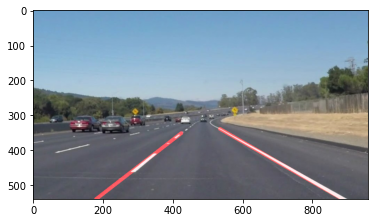

In [15]:
plt.imshow(draw_lane_line(images[0]))

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


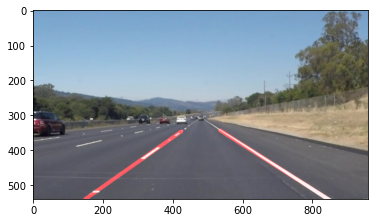

In [16]:
plt.imshow(draw_lane_line(images[1]))

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


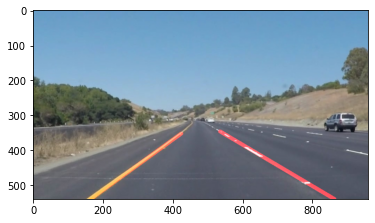

In [17]:
plt.imshow(draw_lane_line(images[2]))

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


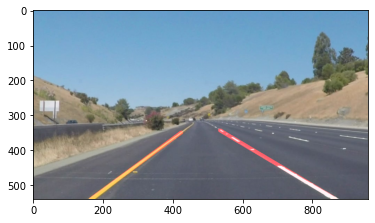

In [18]:
plt.imshow(draw_lane_line(images[3]))

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


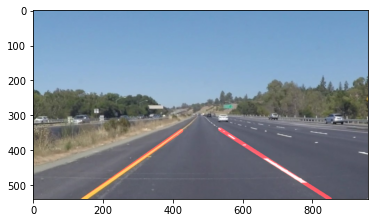

In [19]:
plt.imshow(draw_lane_line(images[4]))

<ipython-input-11-a368d789ba41>:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
<ipython-input-11-a368d789ba41>:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]


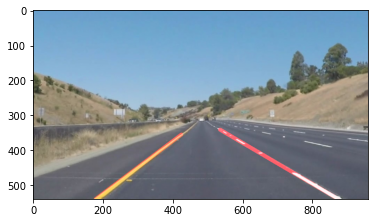

In [20]:
plt.imshow(draw_lane_line(images[5]))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = draw_lane_line(image)
    
    return result

In [23]:
# Function to export all frames from video to jpg files - useful to debug issues
def export_frames(clip, filename):
    f=0
    for frame in clip.iter_frames():
        img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path+tst_input+'/video_frames/'+filename+'_frame'+str(f)+'.jpg', img)
        f+=1
        

Let's try the one with the solid white lane on the right first ...

In [42]:
white_output = path+'/test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                                                                                 | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video D:/Study/Lane-Finding-ND/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video D:/Study/Lane-Finding-ND/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready D:/Study/Lane-Finding-ND/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4
Wall time: 3.42 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [38]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_challenge)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|                                                                                                                                 | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 31 s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


# Pipeline for Challenge video

In [28]:
# Copy control panel from before:

# 1 - Hough parameters:
rho = 2                               # distance resolution in pixels of the Hough grid
theta = np.pi/180                     # angular resolution in radians of the Hough grid
threshold = 15                        # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40                     # minimum number of pixels making up a line
max_line_gap = 20                     # maximum gap in pixels between connectable line segments


# 2 - Angles for left and right lanes
l_angle1 = -25
l_angle2 = -50

r_angle1 = -140
r_angle2 = -160

# 3 - Thickness of plot line
thickness = 10

# 4 - Transparency of plots
alpha = 0.8 # ratio of transparency of original image
beta = 0.9 # ratio of transparency of lines

# 5 - Initialize empty lines and smoothing ratio
prev_lines = np.zeros((2,1,4))
smooth = 0.85



In [29]:
# Some new help functions: 

def get_angle_line2(x1, y1, x2, y2):
    
    """
    This function expects to receive points coordinates as x1, y1, x2, y2 
    (same as the output of the hough lines function) and will return the angle
    between the 2 points p1 (x1, y1) and p2 (x2,y2)
    
    In the version 2.0 we define that p1 will always be the point closes to the car.
    That means it is the point with the larger value of y. It also makes the output more stable.
    """
    
    if y1 > y2:
        # That means p1: (x1, y1) and p2:(x2,y2)
        delta_x = x2 - x1
        delta_y = y2 - y1
    else:
        # That means p1: (x2, y2) and p2: (x1, y1)
        delta_x = x1 - x2
        delta_y = y1 - y2
        

    return math.degrees(math.atan2(delta_y, delta_x))

def HSV(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def challenge_transform_lines(raw_lines, imshape):
    
    """
    Manipulating Hough lines
    This function expects to receive the output of the Hough transform and the shape of the image that will
    receive the drawn lines. It will then manipulate these lines to create a left and right lane line.
    
    CHALLENGE VERSION:
    Added distance from the center of the "car dashboard" as a variable and introduced several constraints
    on how far the hough lines can be from a few key points from the image. All are only dependant on the image
    size. There is a potential to malfunction for other camera angles.
    """

    data=[]

    for i, line in enumerate(raw_lines):
        x1, y1, x2, y2 = [line][0][0]
        angle = get_angle_line2(x1, y1, x2, y2)
        data.append({'line':i, 'angle':angle, 'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})

    df = pd.DataFrame(data ,columns=['line', 'angle', 'x1', 'y1', 'x2', 'y2'])
    df['distance'] = np.sqrt(((df['x1']+df['x2'])/2 - imshape[1]/2)**2 + ((df['y1']+df['y2'])/2 - imshape[0])**2)
    
    # We can now split the dataframe according to several new constraints:
    
    angle1 = df['angle'] < r_angle1
    angle2 = df['angle'] > r_angle2
    x_test1 = df['x1'] > imshape[1]/2
    x_test2 = df['x2'] > imshape[1]/2
    y_test = (df['y1']+df['y2'])/2 > imshape[0]*0.6
    dist_test = df['distance'] < imshape[1]/3

    right_side = df[angle1 & angle2 & x_test1 & x_test2 & y_test & dist_test]  
    
    # Prepare data for our regression:
    x_right = np.hstack((right_side.x1.values, right_side.x2.values))
    y_right = np.hstack((right_side.y1.values, right_side.y2.values))

    # Add bias to X
    Xr = np.vstack([x_right, np.ones(len(x_right))]).T
    
    # ... and calculate the coeficient of the right line
    try:
        coef_r, basis_r = np.linalg.lstsq(Xr, y_right)[0]
        
        yr1 = imshape[0]
        xr1 = np.round((yr1 - basis_r)/coef_r, 0).astype(np.int32)
        xr2 = imshape[1]*0.55
        yr2 = np.round(coef_r * xr2 + basis_r, 0).astype(np.int32)     
        
    except:
        # Error on the function.
        yr1 = 0
        xr1 = 0
        xr2 = 0
        yr2 = 0

    # Now we can do the same thing for the left side:
    
    angle1 = df['angle'] < l_angle1
    angle2 = df['angle'] > l_angle2
    x_test1 = df['x1'] < imshape[1]/2
    x_test2 = df['x2'] < imshape[1]/2
    y_test = (df['y1']+df['y2'])/2 > imshape[0]*0.6
    dist_test = df['distance'] < imshape[1]/3

    left_side = df[angle1 & angle2 & x_test1 & x_test2 & y_test & dist_test]
    
    x_left = np.hstack((left_side.x1.values, left_side.x2.values))
    y_left = np.hstack((left_side.y1.values, left_side.y2.values))

    Xl = np.vstack([x_left, np.ones(len(x_left))]).T
    
    try:
        coef_l, basis_l = np.linalg.lstsq(Xl, y_left)[0]
   
        yl1 = imshape[0]
        xl1 = np.round((yl1 - basis_l)/coef_l, 0).astype(np.int32)
        xl2 = imshape[1]*0.45
        yl2 = np.round(coef_l * xl2 + basis_l, 0).astype(np.int32)
        
    except:
        # Error on the function.
        yl1 = 0
        xl1 = 0
        xl2 = 0
        yl2 = 0

    # And then assign them to a numpy array to be able to use the functions provided:
    lines = np.zeros((2,1,4)).astype(np.int32)
    lines[0,0,:] = [xl1, yl1, xl2, yl2]
    lines[1,0,:] = [xr1, yr1, xr2, yr2]
    
    return lines

In [30]:
# More functions

def line_update(lines, imshape, smooth=0):
    """
    This function expects to receive two sets of lines: the output from the Hough transform
    and the lines found for the previous frame and will return a new set of lines for the current frame.
    """
    
    global prev_lines
    
    smoothed = np.zeros_like(lines).astype(np.float32)
    
    # First we check if any lane is missing from our pipeline
    
    if np.sum(lines[0][0]) == 0:
        # This mean that the algo couldnt find a left lane for this frame.
        # so we will use the last line we found
        lines[0,0,:] = np.copy(prev_lines[0,0,:])
        
    if np.sum(lines[1][0]) == 0:
        # and do the same for the right lane
        lines[1,0,:] = np.copy(prev_lines[1,0,:])
    
    # Now we are going to smooth out the output
    
    # REMINDER OF DIMENSIONS:
    # xl1, yl1 = LOWER LEFT
    # xl2, yl2 = UPPER LEFT
    # xr1, yr1 = LOWER RIGHT
    # xr2, yr2 = UPPER RIGHT
    
    # Clipping parameters for lower points of X
    min_Lxr = imshape[1] * 0.85
    max_Lxr = imshape[1]
    min_Lxl = 0
    max_Lxl = imshape[1] * 0.25
    
    # No clipping for upper points of X at this time.
    
    # Clipping parameters for y
    min_y = 0.6*imshape[0]
    max_y = imshape[0]

    
    if np.sum(prev_lines[0][0]) != 0:
        # This means the previous output is not blank, so we will smooth the transition
        xl1, yl1, xl2, yl2 = lines[0,0,:]
        prev_xl1, prev_yl1, prev_xl2, prev_yl2 = prev_lines[0,0,:]
        
        smoothed_xl1 = smooth*prev_xl1 + (1-smooth)*np.clip(xl1, min_Lxl, max_Lxl)
        smoothed_yl1 = smooth*prev_yl1 + (1-smooth)*yl1 # no clipping needed as its already set as imshape[0] previously
        smoothed_xl2 = smooth*prev_xl2 + (1-smooth)*xl2 
        smoothed_yl2 = smooth*prev_yl2 + (1-smooth)*yl2
        
        smoothed[0,0,:] = [smoothed_xl1, smoothed_yl1, smoothed_xl2, smoothed_yl2]
        
    else:
        smoothed[0,0,:] = np.copy(lines[0,0,:])

        
    if np.sum(prev_lines[1][0]) != 0:
        xr1, yr1, xr2, yr2 = lines[1,0,:]
        #print ("Right Lines: ", lines[1,0,:])
        prev_xr1, prev_yr1, prev_xr2, prev_yr2 = prev_lines[1,0,:]
        #print ("Previous Right Lines: ", prev_lines[1,0,:])
        
        smoothed_xr1 = smooth*prev_xr1 + (1-smooth)*np.clip(xr1, min_Lxr, max_Lxr) 
        smoothed_yr1 = smooth*prev_yr1 + (1-smooth)*yr1  
        smoothed_xr2 = smooth*prev_xr2 + (1-smooth)*xr2 
        smoothed_yr2 = smooth*prev_yr2 + (1-smooth)*yr2
        
        smoothed[1,0,:] = [smoothed_xr1, smoothed_yr1, smoothed_xr2, smoothed_yr2]
        #print ("Smoothed Right Lines: ", smoothed[1,0,:])
        
    else:
        smoothed[1,0,:] = np.copy(lines[1,0,:])
    
    lines = smoothed.astype(np.float32)
    
    # and we update previous line:
    prev_lines = np.copy(lines)
    
    return lines

In [31]:
def challenge_pipeline(img):
    
    imshape = img.shape
    
    hsv = HSV(img)
    
    # White Filter:
    lower_w = np.array([0,0,200])
    upper_w = np.array([180,25,255])

    hsv_w_mask = cv2.inRange(hsv,lower_w, upper_w)

    hsv_w = cv2.bitwise_and(hsv,hsv, mask= hsv_w_mask)

    # Yewllow Filter
    lower_y = np.array([15,75,75])
    upper_y = np.array([35,255,255])

    hsv_y_mask = cv2.inRange(hsv,lower_y, upper_y)

    hsv_y = cv2.bitwise_and(hsv,hsv, mask= hsv_y_mask)
    
    color_masked = cv2.add(hsv_y, hsv_w)

    mean = np.mean(hsv)
    stdev = np.std(hsv)
    canny_low = mean - 0.33*stdev
    canny_high = mean + 0.33*stdev

    edges = canny(color_masked, canny_low, canny_high)    
    
    raw_lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), 
                                minLineLength=min_line_len, maxLineGap=max_line_gap)
        
    lines = challenge_transform_lines(raw_lines, imshape)
    
    return lines

def challenge_draw_lane_line(img, smoothing=0):
    
    imshape = img.shape

    # We first create an empty image to draw on:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Then we find the lines:
    lines = challenge_pipeline(img)
    
    # Update them using our function:
    modlines = line_update(lines, imshape, smoothing)
       
    # Draw the lines on the empty image:
    draw_lines(line_img, modlines, thickness=thickness)
    
    # And finally combine both images:
    annotated_image = cv2.addWeighted(img, alpha, line_img, beta, 0) 
    
    return annotated_image

In [32]:
def process_image_challenge(image):
    
    result = challenge_draw_lane_line(image, smooth)
    
    return result

In [33]:
# First we will extract all frames to be able to work on the images
#export_frames(clip2, 'challenge')

In [54]:
# Read in all images:
images2, filenames2 = read_all_imgs(path+'/test_videos/')

In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))